In [16]:
import os
import platform
import warnings
import numpy as np
from PIL import Image
from pathlib import Path
from anomalib import TaskType


import torch
from torchvision.transforms.v2 import Resize
from torchvision.transforms.v2.functional import to_pil_image, to_image
from anomalib.deploy import OpenVINOInferencer, TorchInferencer



os_name = platform.system()
isLinux = True if os_name.lower() == 'linux' else False

seed = 67
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

warnings.filterwarnings("ignore")
torch.set_float32_matmul_precision('medium')

# 参数配置

In [17]:
configs = {
    "dataset_root": r"/local_data/datasets/3-5-jing" if isLinux else r"F:\Projects\anomalib\notebooks\datasets\3-5 - jing",
    "outputs_path": r"/home/projects/anomalib/outputs" if isLinux else r"F:\Projects\anomalib\notebooks\datasets\3-5 - jing\outputs",
    "model_name": "Fastflow",
}
dataset_root = configs["dataset_root"]
print("dataset_root: {}".format(dataset_root))

normal_folder_path = os.path.join(configs["dataset_root"], "normal")
abnormal_folder_path = os.path.join(configs["dataset_root"], "abnormal")

normal_ouput_path = os.path.join(configs["outputs_path"], configs["model_name"] , "normal_outputs")
abnormal_output_path = os.path.join(configs["outputs_path"], configs["model_name"] , "abnormal_outputs")

dataset_root: /local_data/datasets/3-5-jing


In [18]:
from lightning.pytorch.callbacks import EarlyStopping
from anomalib.callbacks.checkpoint import ModelCheckpoint
from anomalib.callbacks import GraphLogger
from anomalib.loggers import AnomalibMLFlowLogger
from torchvision.transforms.v2 import Resize, RandomHorizontalFlip, Compose, Normalize, ToDtype,RandomAffine,RandomPerspective, Grayscale, ToTensor, Transform, GaussianBlur
from anomalib.data.image.folder import Folder, FolderDataset





class ExtractBChannel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        pass
    
    # RGB (N, 3, H, W) 的tensor类型
    def forward(self, img):
        
        if not isinstance(img, torch.Tensor): img = torch.Tensor(img)
        
        tmp_img = img.clone()
        if len(img.shape) == 3: tmp_img = tmp_img.unsqueeze(0)
        bs, channels, height, width = tmp_img.shape
        
        if channels == 1: tmp_img = tmp_img.repeat(1,3,1,1)
        
        b_channel = tmp_img[:, 2, :, :]                      # 提取 B 通道（张量的第三个通道，索引为2）
        b_channel[b_channel < 100/255] = 0
        # b_channel[b_channel >= 100/255] = 1                # 不能添加
        b_channel_3 = b_channel.repeat(1, 3, 1, 1)
        
        out_img = b_channel_3
        if len(img.shape) == 3: out_img = out_img.squeeze(0)
        
        #print("{} --> {} --> {} -- {};".format(img.shape, tmp_img.shape, b_channel.shape, out_img.shape))
        return out_img


train_transform = Compose(
    [
        ExtractBChannel(),                                                # 0~1之间
        #ToTensor(),
        #ToDtype(torch.uint8, scale=True),
        Resize((256, 256)),                                               # 如果resizeHW不一致，会引起fastflow报layernorm错误
        # RandomHorizontalFlip(p=0.3),                                    # 无seed, 0.90 --> 0.95
        #RandomAffine(degrees=(-5, 5), translate=(0.95, 0.95),scale=(0.95, 0.95), ),     # onnx 不支持 grid_sampler.
        #RandomPerspective(distortion_scale=0.1, p=0.3),
        #ToDtype(torch.float32, scale=True),                              # Normalize expects float input
        Normalize(mean=[0.406, 0.406, 0.406], std=[0.225, 0.225, 0.225]),
    ],
)

eval_transform = Compose(
    [
        ExtractBChannel(),          
        # ToTensor(),
        #ToDtype(torch.uint8, scale=True),
        Resize((256, 256)),
        #RandomHorizontalFlip(p=0.3),  
        #RandomAffine(degrees=(-5, 5), translate=(0.95, 0.95),scale=(0.95, 0.95), ), 
        #RandomPerspective(distortion_scale=0.1, p=0.3),
        #ToDtype(torch.float32, scale=True), 
        Normalize(mean=[0.406, 0.406, 0.406], std=[0.225, 0.225, 0.225]),
    ],
)

In [19]:
def draw_pic(inferencer:OpenVINOInferencer, torch_inferencer, transform, png_files, input_path, outpath):
    from anomalib.data.utils import read_image
    import time
    import cv2
    import matplotlib.pyplot as plt


    for file_name in png_files:
        # 记录开始时间
        start_time = time.time()
        
        # 读取图像
        image_path = os.path.join(input_path, file_name)
        image = read_image(path=image_path)                      # HWC
        CHW_image = read_image(path=image_path, as_tensor=True)  # CHW
        print("\n===> {};".format(image_path))
        
        
        # 图像transform
        filter_image: torch.tensor = ExtractBChannel()(CHW_image) 
        transform_image: torch.tensor = transform(CHW_image)
        
        
        # 图像推理
        tmp = np.array(filter_image.permute(1,2,0), dtype=np.float32)
        predictions = inferencer.predict(image=tmp)        #! 注：如果使用vino，输入的image参数如果不是path，那么其shape只能是HWC
        #predictions = torch_inferencer.predict(image=transform_image)
        print(predictions.pred_score, predictions.pred_label)
        #! 🎯 inferencer.predict接受原始图像，
        #! 内部通过metadata和model在forward函数(非pre_process函数)中调用标准化的transform对图像处理;
        #! 见/home/projects/anomalib/docs/source/snippets/data/transforms/inference.txt
        #! 注: 1. 模型导出时，生成的bin/onnx、json等文件中均不包含训练时使用到的transform操作，包括数据增强相关的操作和标准化相关的操作
        #! 注: 2. 而predict推理时，会进行的预处理操作是标准化操作，比如normalize，但是这里的normalize是除以255的方式，而不是标准正太分布。
        #! 通过以上总结，可知，我们需要1. 修改训练时的normalize；2. 将ExtractBChannel操作要出现在训练时的transform以外，还需要封装成一个数据预处理操作。在模型推理之前对图像进行额外的预处理操作。
        
        # 记录结束时间
        end_time = time.time()
        elapsed_time = end_time - start_time  # 计算耗时
        print(f"Prediction took {elapsed_time:.4f} seconds.")
        
        
        # 可视化
        transform_image_show = transform_image.permute(1,2,0)    # CHW -> HWC
        filter_image_show = filter_image.permute(1,2,0)    # CHW -> HWC
        
        #print("image: {}; filter_image: {}; transform_image: {}; predictions.heat_map: {};".format(image.shape, filter_image.shape, transform_image.shape, predictions.heat_map.shape))
        
        
        
        # 创建一个新的图形窗口
        fig, axs = plt.subplots(1, 6, figsize=(18, 6))

        # 原始图像
        axs[0].imshow(image)
        axs[0].set_title('Original Image')
        axs[0].axis('off')  # 关闭坐标轴
        
        # 训练用图像
        tmp1 = cv2.normalize(filter_image_show.numpy(), None, 0, 1, cv2.NORM_MINMAX)
        axs[1].imshow(tmp1)
        axs[1].set_title('Filter Image')
        axs[1].axis('off')  # 关闭坐标轴
        
        # 训练用图像
        tmp2 = cv2.normalize(transform_image_show.numpy(), None, 0, 1, cv2.NORM_MINMAX)
        axs[2].imshow(tmp2)
        axs[2].set_title('Train Image')
        axs[2].axis('off')  # 关闭坐标轴

        # 热图
        axs[3].imshow(predictions.heat_map, cmap='hot', interpolation='nearest')
        axs[3].set_title('Heat Map')         #! 热力图是anomaly_map与原始图像的加权结合
        axs[3].axis('off')  # 关闭坐标轴

        # 预测掩模
        axs[4].imshow(predictions.pred_mask, cmap='gray', interpolation='nearest')
        axs[4].set_title('Predicted Mask')
        axs[4].axis('off')  # 关闭坐标轴

        # 预测掩模
        axs[5].imshow(predictions.anomaly_map, cmap='gray', interpolation='nearest')
        axs[5].set_title('Anomaly Map')      
        axs[5].axis('off')  # 关闭坐标轴 
        

        # 添加文本信息到图形的上方中间位置
        fig_text_x = 0.1   # x坐标在图形宽度的中心位置
        fig_text_y = 0.95  # y坐标稍微靠近图形的顶部，避免与子图重叠
        fig.text(fig_text_x, fig_text_y,
                f'Prediction Time: {elapsed_time:.4f} s\n'
                f'Predicted Class: {predictions.pred_label}\n'
                f'Threshold: {0.5}\n'
                f'Score: {predictions.pred_score:.4f}' if hasattr(predictions, 'pred_score') else '',
                ha='left', va='center', fontsize=12,
                bbox=dict(boxstyle="round", fc="w", ec="0.5", alpha=0.5))  

        # 显示整个图形
        plt.tight_layout()  # 调整子图间的间距
        plt.savefig(os.path.join(outpath, file_name))
        plt.close()
        
    print("Done")

In [20]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


def pplot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

# Custom 数据集配置

Folder的理解:

1. 训练集中全部是正常样本；
2. 正常样本集中的部分(normal_split_ratio)样本被均等(val_split_ratio)放入到验证集和测试集中。
3. test_split_ratio似乎和normal_split_ratio一样。
4. 🎯 需要确保训练集不存在正常样本；测试集不存在样本；验证集是全部正样本和全部负样本。

比如：val_split_ratio=0.5时：82 | 27, 10 | 27, 10|; val_split_ratio=0.1时：82 | 5, 2 | 49, 18|;

In [21]:
folder_datamoduleA = Folder(
    name="3-5",
    root=dataset_root,
    normal_dir="normal", abnormal_dir="abnormal",
    task=TaskType.CLASSIFICATION,
    num_workers=0,                                           #! in jupyter, need to be zero. and non-0 in python main;
    train_batch_size = 16, eval_batch_size = 8,              #! 计算的时候会使用cuda，因此需要限制BS不适用默认值32；
    train_transform=train_transform, eval_transform=eval_transform,
    seed = seed,
    test_split_ratio=0.02,    #! 控制正常样本，在非训练集和训练集中的数量比例
    val_split_ratio=0.98,     #! 控制剩余正常样本和异常样本，在验证集和测试集中的数量比例
)

folder_datamoduleB = Folder(
    name="3-5",
    root=dataset_root,
    normal_dir="normal", abnormal_dir="abnormal",
    task=TaskType.CLASSIFICATION,
    num_workers=0,                                           #! in jupyter, need to be zero. and non-0 in python main;
    train_batch_size = 16, eval_batch_size = 8,              #! 计算的时候会使用cuda，因此需要限制BS不适用默认值32；
    train_transform=train_transform, eval_transform=eval_transform,
    seed = seed,
    test_split_ratio=0.98,    #! 控制正常样本，在非训练集和训练集中的数量比例
    val_split_ratio=0.98,     #! 控制剩余正常样本和异常样本，在验证集和测试集中的数量比例
)

folder_datamoduleC = Folder(
    name="3-5",
    root=dataset_root,
    normal_dir="normal", abnormal_dir="abnormal_filtered",
    task=TaskType.CLASSIFICATION,
    num_workers=0,                                           #! in jupyter, need to be zero. and non-0 in python main;
    train_batch_size = 16, eval_batch_size = 8,              #! 计算的时候会使用cuda，因此需要限制BS不适用默认值32；
    train_transform=train_transform, eval_transform=eval_transform,
    seed = seed,
    test_split_ratio=0.02,    #! 控制正常样本，在非训练集和训练集中的数量比例
    val_split_ratio=0.04,     #! 控制剩余正常样本和异常样本，在验证集和测试集中的数量比例
)

folder_datamoduleA.setup()    # 进行数据集分割
folder_datamoduleB.setup()    # 进行数据集分割
folder_datamoduleC.setup()    # 进行数据集分割

train_loader = folder_datamoduleA.train_dataloader()
val_loader   = folder_datamoduleB.val_dataloader()
test_loader  = folder_datamoduleC.test_dataloader()

# train_loader_lst  = [train_loader]
# val_loader_lst    = [train_loader, val_loader, test_loader]
# test_loader_lst   = [train_loader, val_loader, test_loader]

INFO:anomalib.data.base.datamodule:No normal test images found. Sampling from training set using a split ratio of 0.02
INFO:anomalib.data.base.datamodule:No normal test images found. Sampling from training set using a split ratio of 0.98
INFO:anomalib.data.base.datamodule:No normal test images found. Sampling from training set using a split ratio of 0.02
            might be empty or devoid of either normal or anomalous images.


## ==> 分析训练集、验证集、测试集的数据量以及类别分布

In [22]:
def ana_dataloader(dataloader):
    from collections import Counter
    
    # 统计dataloader中样本的类别比例
    all_labels = []
    all_image_paths = []
    for data in dataloader:
        image_paths: list = data["image_path"]
        labels: torch.tensor = data["label"]
        all_labels.extend(labels.tolist())
        all_image_paths.extend(image_paths)
    label_frequency = Counter(all_labels)
    print("label频率分布：{}".format(label_frequency))
    print("image_paths({})[:5]: \n{}".format(len(all_image_paths), all_image_paths[:5]))

In [23]:
# Train images
i, data = next(enumerate(train_loader))
print(data.keys(), data["image"].shape, type(data["image_path"]), type(data["label"]), type(data["image"]))
ana_dataloader(train_loader)

dict_keys(['image_path', 'label', 'image']) torch.Size([16, 3, 256, 256]) <class 'list'> <class 'torch.Tensor'> <class 'torch.Tensor'>
label频率分布：Counter({0: 100})
image_paths(100)[:5]: 
['/local_data/datasets/3-5-jing/normal/13__DA1479053.png', '/local_data/datasets/3-5-jing/normal/17__DA2951215 (3).png', '/local_data/datasets/3-5-jing/normal/5__DA2951215.png', '/local_data/datasets/3-5-jing/normal/55__DA2951215.png', '/local_data/datasets/3-5-jing/normal/71__DA1479053.png']


In [24]:
# Val images
i, data = next(enumerate(val_loader))
print(data.keys(), data["image"].shape, type(data["image_path"]), type(data["label"]), type(data["image"]))
ana_dataloader(val_loader)

dict_keys(['image_path', 'label', 'image']) torch.Size([8, 3, 256, 256]) <class 'list'> <class 'torch.Tensor'> <class 'torch.Tensor'>
label频率分布：Counter({0: 97, 1: 52})
image_paths(149)[:5]: 
['/local_data/datasets/3-5-jing/abnormal/11__DA1479053 (2).png', '/local_data/datasets/3-5-jing/abnormal/11__DA2951175 (2).png', '/local_data/datasets/3-5-jing/abnormal/11__DA2951175.png', '/local_data/datasets/3-5-jing/abnormal/11__DA2951225.png', '/local_data/datasets/3-5-jing/abnormal/13__DA1479053 (2).png']


In [25]:
# Test images
i, data = next(enumerate(test_loader))
print(data.keys(), data["image"].shape, type(data["image_path"]), type(data["label"]), type(data["image"]))
ana_dataloader(test_loader)

dict_keys(['image_path', 'label', 'image']) torch.Size([8, 3, 256, 256]) <class 'list'> <class 'torch.Tensor'> <class 'torch.Tensor'>
label频率分布：Counter({1: 28, 0: 2})
image_paths(30)[:5]: 
['/local_data/datasets/3-5-jing/abnormal_filtered/11__DA1479053 (3).png', '/local_data/datasets/3-5-jing/abnormal_filtered/11__DA1479053.png', '/local_data/datasets/3-5-jing/abnormal_filtered/11__DA2951175 (3).png', '/local_data/datasets/3-5-jing/abnormal_filtered/13__DA2951215 (2).png', '/local_data/datasets/3-5-jing/abnormal_filtered/13__DA2951215 (3).png']


## ==> 查看图像内容

torch.Size([8, 3, 256, 256])


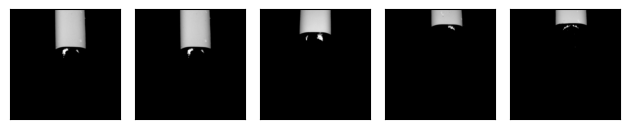

In [26]:
total_images = []
print(data["image"].shape)
for i in range(data["image"].shape[0])[:5]:
    test_img = data["image"][i]
    total_images.append(test_img)
pplot(total_images)

In [27]:
from anomalib.data.utils import read_image

temp_path = r"/local_data/datasets/3-5-jing/normal/1__DA2951175 (2).png" if isLinux else r"F:\Projects\anomalib\notebooks\datasets\3-5 - jing\normal\1__DA2951175 (2).png"

test_image = read_image(temp_path, as_tensor=True)
print("处理前的数据 : {}, {}, {};".format(test_image.min(), test_image.max(), test_image.mean()))

for index, trans in enumerate(train_transform.transforms):
    tmp_image = trans(test_image)
    print("transform.{}: {}, {}, {};".format(index, tmp_image.min(), tmp_image.max(), tmp_image.mean()))

处理前的数据 : 0.0, 0.9725490808486938, 0.06547369062900543;
transform.0: 0.0, 0.9725490808486938, 0.04567107558250427;
transform.1: 0.0, 0.9362553358078003, 0.06547410041093826;
transform.2: -1.804444432258606, 2.517995834350586, -1.5134505033493042;


# 模型选择和优化器配置

In [28]:
from anomalib.engine import Engine
from anomalib.models import Padim, Patchcore, Stfpm, Fastflow

model_checkpoint = ModelCheckpoint(mode="max", monitor="image_F1Score")
early_stopping = EarlyStopping(monitor="image_F1Score", mode="max", patience=5)
graph_logger = GraphLogger()

In [30]:
callbacks = [
    model_checkpoint,
    early_stopping,
    graph_logger,
]


if configs["model_name"] == "Patchcore":
    model = Patchcore()
    engine = Engine(task=TaskType.CLASSIFICATION, 
                    image_metrics=["F1Score","AUROC"], 
                    pixel_metrics=["F1Score","AUROC"], 
                    # callbacks= callbacks
                    )
    # engine.train(model=model, 
    #              train_dataloaders=train_loader_lst, 
    #              val_dataloaders=val_loader_lst, 
    #              test_dataloaders=test_loader_lst)
    engine.train(model=model, 
                 train_dataloaders=train_loader, 
                 val_dataloaders=val_loader, 
                 test_dataloaders=test_loader)
elif configs["model_name"] == "Fastflow":
    model = Fastflow()
    engine = Engine(task=TaskType.CLASSIFICATION,
                    image_metrics=["F1Score","AUROC"], pixel_metrics=["F1Score","AUROC"],
                    logger=False, callbacks= callbacks,
                    accelerator="auto",                       # \<"cpu", "gpu", "tpu", "ipu", "hpu", "auto">,
                    max_epochs=1,                            #! 希望赋值给Lightning Trainer的参数必须全部放在已标明参数的最后面
                    )
    engine.train(model=model, 
                 train_dataloaders=train_loader, 
                 val_dataloaders=val_loader, 
                 test_dataloaders=val_loader)
else:
    model = Patchcore()
    engine = Engine(task=TaskType.CLASSIFICATION)
    engine.train(model=model, 
                 train_dataloaders=train_loader, 
                 val_dataloaders=val_loader, 
                 test_dataloaders=val_loader)
    

print(engine.trainer.default_root_dir)

INFO:anomalib.models.components.base.anomaly_module:Initializing Fastflow model.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
INFO:timm.models._hub:[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name                  | Type                     | Params | Mode 
---------------------------------------------------------------------------
0 | loss                  | FastflowLoss             | 0      | train
1 | _transform            | Compose                  | 0      | train
2 | normalization_metrics | MetricCollection         | 0      | tr

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:anomalib.callbacks.timer:Training took 43.99 seconds
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

INFO:anomalib.callbacks.timer:Testing took 69.64969515800476 seconds
Throughput (batch_size=8) : 2.1392771305313545 FPS


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │     0.981760561466217     │
│       image_F1Score       │    0.9444444179534912     │
└───────────────────────────┴───────────────────────────┘

/home/projects/results/Fastflow/latest


# 模型导出

In [ ]:
# from anomalib.deploy import ExportType
# engine.export(model=model, export_type=ExportType.OPENVINO)  # torch.onnx.export op=16
# print(f"Model save to {engine.trainer.default_root_dir}).") 

from anomalib.deploy import ExportType
engine.export(model=model, export_type=ExportType.OPENVINO)  # torch.onnx.export op=16
engine.export(model=model, export_type=ExportType.ONNX)  # torch.onnx.export op=16
engine.export(model=model, export_type=ExportType.TORCH)  # torch.onnx.export op=16
print(f"Model save to {engine.trainer.default_root_dir}).") 

opset_versissssson: 14;


INFO:root:Exported model to /home/projects/results/Fastflow/latest/weights/openvino/model.xml


opset_versissssson: 14;


INFO:root:Exported model to /home/projects/results/Fastflow/latest/weights/onnx/model.onnx
INFO:root:Exported model to /home/projects/results/Fastflow/latest/weights/torch/model.pt


Model save to /home/projects/results/Fastflow/latest).


In [ ]:
# model_output_path=Path(engine.trainer.default_root_dir)
# openvino_model_path = model_output_path / "weights" / "openvino" / "model.bin"
# metadata_path = model_output_path / "weights" / "openvino" / "metadata.json"
# print(openvino_model_path.exists(), metadata_path.exists())
from anomalib.deploy import OpenVINOInferencer, TorchInferencer

model_output_path=Path(engine.trainer.default_root_dir)
# model_output_path = Path(r"/home/projects/results/Fastflow/latest")
openvino_model_path = model_output_path / "weights" / "onnx" / "model.onnx"
metadata_path = model_output_path / "weights" / "onnx" / "metadata.json"
ckpt_model_path = model_output_path / "weights" / "torch" / "model.pt"
print(openvino_model_path.exists(), metadata_path.exists(), ckpt_model_path.exists())


True True True


# 模型测试

In [ ]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,    # Path to the OpenVINO IR model.
    metadata=metadata_path,      # Path to the metadata file.
    device="AUTO",               # We would like to run it on an Intel CPU.
)

torch_inferencer = TorchInferencer(ckpt_model_path)

In [ ]:
torch_inferencer.model.transform

Compose(
      Resize(size=[256, 256], interpolation=InterpolationMode.BILINEAR, antialias=False)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

In [ ]:
# 待测试图像
normal_png_files = [f for f in os.listdir(normal_folder_path) if f.endswith('.png')][:5]
abnormal_png_files = [f for f in os.listdir(abnormal_folder_path) if f.endswith('.png')][:5]
print(normal_png_files)
print(abnormal_png_files)


import shutil
# 输出路径确认
if os.path.exists(normal_ouput_path): 
    shutil.rmtree(normal_ouput_path)
if os.path.exists(abnormal_output_path): 
    shutil.rmtree(abnormal_output_path)
os.makedirs(normal_ouput_path)
os.makedirs(abnormal_output_path)


# 模型测试
draw_pic(inferencer, torch_inferencer, train_transform, normal_png_files, normal_folder_path, normal_ouput_path)
draw_pic(inferencer, torch_inferencer, train_transform, abnormal_png_files, abnormal_folder_path, abnormal_output_path)

['11__DA2951215 (4).png', '17__DA2951215 (3).png', '59__DA1479053.png', '67__DA2951175.png', '59__DA2951175.png']
['71__DA2951215.png', '69__DA2951225 (2).png', '5__DA2951225.png', '13__DA2951175.png', '17__DA2951225.png']

===> /local_data/datasets/3-5-jing/normal/11__DA2951215 (4).png;
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
0.15258617148454573 LabelName.NORMAL
Prediction took 1.1802 seconds.

===> /local_data/datasets/3-5-jing/normal/17__DA2951215 (3).png;
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
0.13462447928461213 LabelName.NORMAL
Prediction took 1.0889 seconds.


===> /local_data/datasets/3-5-jing/normal/59__DA1479053.png;
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
0.4438535835224849 LabelName.NORMAL
Prediction took 0.9160 seconds.



===> /local_data/datasets/3-5-jing/normal/67__DA2951175.png;
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
0.1877837405138954 LabelName.NORMAL
Prediction took 1.1105 seconds.



===> /local_data/datasets/3-5-jing/normal/59__DA2951175.png;
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
0.27357514890748513 LabelName.NORMAL
Prediction took 0.9661 seconds.
Done

===> /local_data/datasets/3-5-jing/abnormal/71__DA2951215.png;
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
0.9015370254314499 LabelName.ABNORMAL
Prediction took 1.0223 seconds.

===> /local_data/datasets/3-5-jing/abnormal/69__DA2951225 (2).png;
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448])


===> /local_data/datasets/3-5-jing/abnormal/5__DA2951225.png;
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
0.8170319617869952 LabelName.ABNORMAL
Prediction took 1.0010 seconds.



===> /local_data/datasets/3-5-jing/abnormal/13__DA2951175.png;
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
0.8186749472043311 LabelName.ABNORMAL
Prediction took 1.2177 seconds.



===> /local_data/datasets/3-5-jing/abnormal/17__DA2951225.png;
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
torch.Size([3, 2048, 2448]) --> torch.Size([1, 3, 2048, 2448]) --> torch.Size([1, 2048, 2448]) -- torch.Size([3, 2048, 2448]);
0.8667581616047777 LabelName.ABNORMAL
Prediction took 1.0465 seconds.
Done
